In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os


In [2]:
train_image_dir = "Data/train"
categories = ["mask", "nomask"]

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 128
TRAIN_IMGS = 23282
MAX_TRAIN_STEPS = 200
STEP_COUNT = min(MAX_TRAIN_STEPS, TRAIN_IMGS//BATCH_SIZE)
NB_EPOCHS = 20

In [4]:
image_array = []
label_array = []
for category in categories:
    train_path = os.path.join(train_image_dir, category)
    for img in os.listdir(train_path):
        img_path = os.path.join(train_path, img)
        image = load_img(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image = img_to_array(image)
        image = preprocess_input(image)

        image_array.append(image)
        label_array.append(category)


In [5]:
lb = LabelBinarizer()
label_array = lb.fit_transform(label_array)
labels = to_categorical(label_array)

images = np.array(image_array, dtype="float32")
labels = np.array(labels)

(train_x, test_x, train_y, test_y) = train_test_split(images, labels,
    test_size=0.20, stratify=labels, random_state=2)

In [6]:
train_datagen = ImageDataGenerator(
    featurewise_center = False, 
    samplewise_center = False,
    rotation_range = 15, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],  
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode="nearest")

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, IMAGE_HEIGHT, IMAGE_WIDTH)
else:
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    
model = tf.keras.applications.MobileNetV2(include_top=False, 
                    weights='imagenet', input_tensor=Input(input_shape))
for layer in model.layers:
    layer.trainable = False
    
AvgPool=AveragePooling2D(pool_size=(2,2))(model.output)
flat1=Flatten(name='flatten')(AvgPool)
class1=Dense(128, activation='relu',kernel_initializer='he_uniform')(flat1)
class2=Dropout(0.5)(class1)
output=Dense(2, activation='softmax')(class2)

model=Model(inputs=model.inputs, outputs=output)


In [8]:
ADAM_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
            optimizer=ADAM_OPTIMIZER,
            metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)
callbacks_list = [early, reduce_lr]

In [9]:
loss_history=[model.fit_generator(
    train_datagen.flow(train_x,train_y),
    steps_per_epoch=STEP_COUNT,
    epochs=NB_EPOCHS,
    validation_data=(test_x, test_y),
    validation_steps=len(test_x) // BATCH_SIZE,
    callbacks=callbacks_list)]


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
181/181 [==============================] - 98s 541ms/step - loss: 0.3468 - accuracy: 0.9583 - val_loss: 0.1942 - val_accuracy: 0.9794
Epoch 2/20
181/181 [==============================] - 94s 520ms/step - loss: 0.2565 - accuracy: 0.9667 - val_loss: 0.0593 - val_accuracy: 0.9899
Epoch 3/20
181/181 [==============================] - 100s 552ms/step - loss: 0.0800 - accuracy: 0.9805 - val_loss: 0.0411 - val_accuracy: 0.9882
Epoch 4/20
181/181 [==============================] - 97s 538ms/step - loss: 0.0488 - accuracy: 0.9843 - val_loss: 0.0483 - val_accuracy: 0.9852
Epoch 5/20
181/181 [==============================] - 97s 537ms/step - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.0241 - val_accuracy: 0.9936
Epoch 6/20
181/181 [==============================] - 97s 536ms/step - loss: 0.0460 - accuracy: 0.9853 - val_loss: 0.0271 - val_accuracy: 0.9929
Epoch 7/20
181/181 [==============================] -

In [13]:
model.save("MaskDetection.model", save_format="h5")

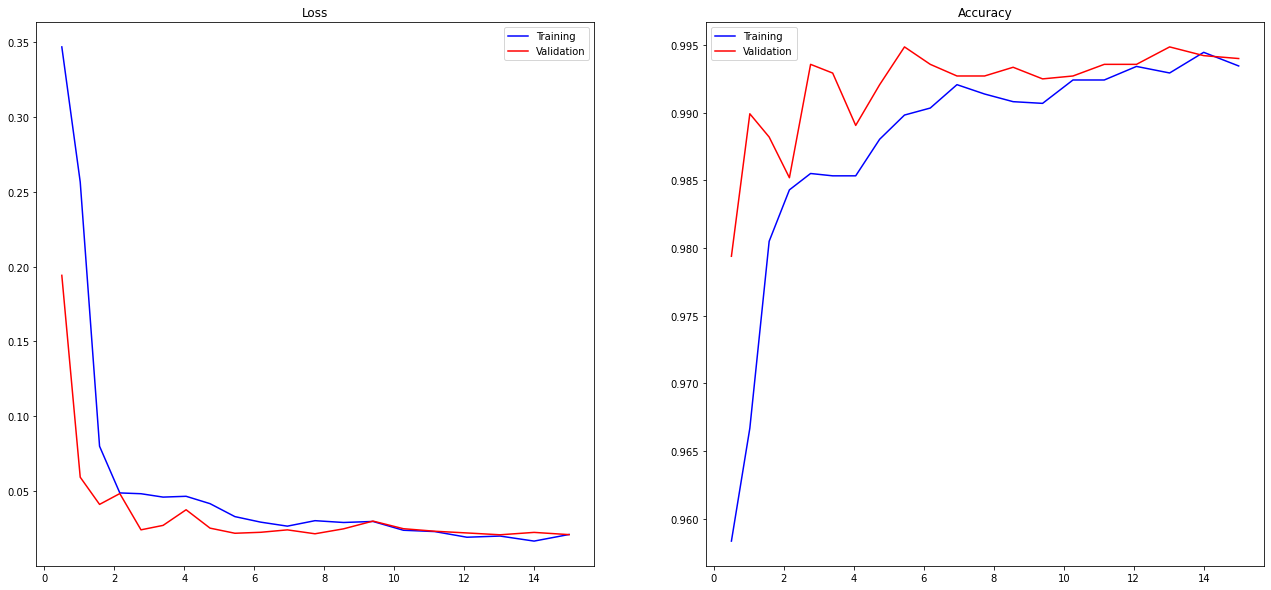

In [10]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    _ = ax1.plot(epich, np.concatenate(
        [mh.history['loss'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Accuracy')
    

show_loss(loss_history)

In [11]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = model.predict(test_x, batch_size=BATCH_SIZE)
predictions = np.argmax(predictions, axis=1)

print(classification_report(test_y.argmax(axis=1), predictions,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

        mask       1.00      0.99      0.99      2329
      nomask       0.99      1.00      0.99      2328

    accuracy                           0.99      4657
   macro avg       0.99      0.99      0.99      4657
weighted avg       0.99      0.99      0.99      4657

